#  Preprocessing 

In [69]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

In [70]:
diseases  = ['Early_blight','Late_blight', 'healthy']

In [71]:
IMAGE_SIZE = 256 
BATCH_SIZE = 16 
CHANNELS = 1
EPOCHS = 8

In [72]:
class Preprocessing:
    
    def __init__(self,DIR):
        self.path = DIR
    
    def import_dataset(self):
        features = []
        labels = []
        for disease in diseases:
            path = os.path.join(self.path,f'Potato___{disease}')
            label = disease
            for img in os.listdir(path):
                img_path = os.path.join(path,img)
                img_array = cv.imread(img_path)
                features.append(img_array)
                labels.append(label)
        return features, labels
    
    def resize_and_rescale(self,features_resize,IMAGE_SIZE):
        for i in range(len(features_resize)):
            features_resize[i] = cv.resize(features_resize[i],(IMAGE_SIZE,IMAGE_SIZE), interpolation = cv.INTER_CUBIC)
        feature_normalize = np.array(features_resize)
        feature_normalize = feature_normalize/255.0
        return feature_normalize

    
    def label_encode(self,labels):
        le = LabelEncoder()
        labels = le.fit_transform(labels)
        return labels
    
    def reshape_image(self, images_normalized, IMAGE_SIZE):
        feature_reshaped = []
        for i in range(len(images_normalized)):
            feature_reshaped.append(images_normalized[i].reshape(IMAGE_SIZE,IMAGE_SIZE,1))
        return feature_reshaped
    
    def grey_scale(self, images):
        for i in range(len(images)):
            img_array = images[i]
            images[i] = cv.cvtColor(img_array, cv.COLOR_BGR2GRAY)
        return images
    
    def split_data(self,feature_reshape, labels, test_size, val_size):
        X,y= shuffle(feature_reshape,labels, random_state=1)
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=1)
        return X_train, X_test, y_train, y_test,X_val, y_val
        
    
    def plot_sample(self, sample_size):
        plt.figure(figsize=(15,15))
        for i in range(sample_size):
            ax = plt.subplot(int(sample_size/4)+1,4,i+1)
            plt.imshow(X_test[i], cmap='gray')
            plt.title(diseases[y_test[i]])

In [73]:
bp = Preprocessing('PlantVillage')

In [74]:
images, labels = bp.import_dataset()

Text(0.5, 0, "['healthy']")

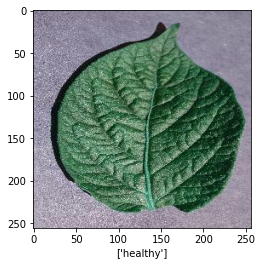

In [75]:
plt.imshow(images[2000])
plt.xlabel([labels[2000]])

In [76]:
images_grey = bp.grey_scale(images)

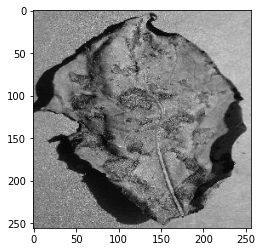

In [77]:
plt.imshow(images_grey[0],cmap='gray')

In [78]:
images_resized = bp.resize_and_rescale(images_grey, IMAGE_SIZE=IMAGE_SIZE)

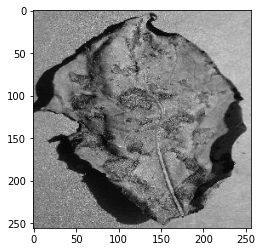

In [79]:
plt.imshow(images_resized[0],cmap='gray')

In [80]:
labels = bp.label_encode(labels)
set(labels)

{0, 1, 2}

In [81]:
images_reshaped = bp.reshape_image(images_resized, IMAGE_SIZE)

In [82]:
images_reshaped[0].shape

(256, 256, 1)

In [83]:
X_train, X_test, y_train, y_test,X_val, y_val = bp.split_data(images_reshaped,labels, test_size=0.2,val_size=0.1)
len(X_train),len(X_test), len(X_val), len(y_train),len(y_test),len(y_val)

(1548, 431, 173, 1548, 431, 173)

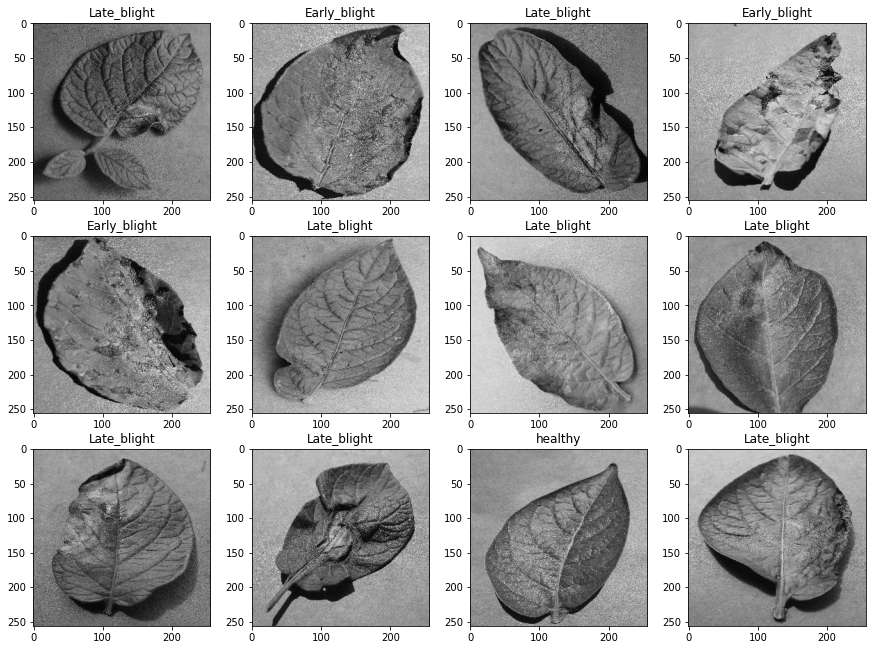

In [84]:
bp.plot_sample(12)

# Model Building

In [43]:
class model_building:
    
    def __init__(self, X_train, X_test,X_val,y_train,y_test,y_val):
        self.X_train = X_train
        self.X_test = X_test
        self.X_val = X_val
        self.y_train = y_train
        self.y_test = y_test
        self.y_val = y_val
    
    def building_model(self):
        data_augmentation = tf.keras.Sequential([
            layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
            layers.experimental.preprocessing.RandomRotation(0.2)
        ])
        model = models.Sequential([
            data_augmentation,
            layers.Conv2D(filters=32, kernel_size=(3, 3),activation = 'relu', input_shape=(256, 256, 1)),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(filters=32, kernel_size=(3, 3),activation = 'relu', input_shape=(256, 256, 1)),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(filters=32, kernel_size=(3, 3),activation = 'relu', input_shape=(256, 256, 1)),
            layers.MaxPooling2D((2,2)),
            layers.Flatten(),
            layers.Dense(64,activation='relu'),
            layers.Dense(3,activation='softmax'),
        ])
        
        
        return model
    
    def train(self,models, epochs):
        models.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      optimizer="adam",
                      metrics=["accuracy"])
        
        X_train = np.array(self.X_train)
        y_train = np.array(self.y_train)
        X_val = np.array(self.X_val)
        y_val = np.array(self.y_val)
        model_history = models.fit(X_train, y_train, epochs=epochs,validation_data=(X_val, y_val))
        
        
        return model_history

    
    def test(self,model):
        X_test = np.array(self.X_test)
        y_test = np.array(self.y_test)
        evaluation = model.evaluate(X_test,y_test)
        y_pred = model_new.predict(X_test)
        y_pred_classes = [np.argmax(x) for x in y_pred]
        report = classification_report(y_test, y_pred_classes,zero_division=1)
        
        return (print(evaluation,'\n', report))

    def graphs(self, model, epochs):
        plt.figure(figsize=(10,5))
        ax = plt.subplot(1,2,1)
        acc = model.history['accuracy'] 
        val_acc = model.history['val_accuracy']
        plt.plot(range(epochs),acc, label ='Train Accuracy')
        plt.plot(range(epochs),val_acc, label = "validation accuracy")
        plt.legend()
        ax = plt.subplot(1,2,2)
        loss = model.history['loss'] 
        val_loss = model.history['val_loss']
        plt.plot(range(epochs),loss, label ='Train loss')
        plt.plot(range(epochs),val_loss, label = "validation loss")
        plt.legend()

In [44]:
md = model_building(X_train, X_test,X_val,y_train,y_test,y_val)

In [45]:
model_new = md.building_model()

In [46]:
model_history = md.train(model_new,epochs=20)

Epoch 1/20
49/49 [==============================] - 109s 2s/step - loss: 0.7906 - accuracy: 0.6460 - val_loss: 0.8605 - val_accuracy: 0.6647
Epoch 2/20
49/49 [==============================] - 91s 2s/step - loss: 0.5041 - accuracy: 0.8140 - val_loss: 0.3903 - val_accuracy: 0.8786
Epoch 3/20
49/49 [==============================] - 92s 2s/step - loss: 0.4232 - accuracy: 0.8450 - val_loss: 0.3892 - val_accuracy: 0.8382
Epoch 4/20
49/49 [==============================] - 92s 2s/step - loss: 0.3999 - accuracy: 0.8547 - val_loss: 0.3200 - val_accuracy: 0.8671
Epoch 5/20
49/49 [==============================] - 92s 2s/step - loss: 0.3414 - accuracy: 0.8727 - val_loss: 0.3394 - val_accuracy: 0.8671
Epoch 6/20
49/49 [==============================] - 90s 2s/step - loss: 0.3262 - accuracy: 0.8773 - val_loss: 0.2773 - val_accuracy: 0.8786
Epoch 7/20
49/49 [==============================] - 91s 2s/step - loss: 0.3496 - accuracy: 0.8695 - val_loss: 0.3108 - val_accuracy: 0.8555
Epoch 8/20
49/49 [=

In [47]:
md.test(model_new)

14/14 [==============================] - 7s 467ms/step - loss: 0.2722 - accuracy: 0.8886
[0.27217426896095276, 0.8886311054229736] 
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       198
           1       0.95      0.83      0.89       205
           2       0.66      0.68      0.67        28

    accuracy                           0.89       431
   macro avg       0.82      0.83      0.82       431
weighted avg       0.89      0.89      0.89       431



In [48]:
model_new.save('model2.h5')

In [85]:
model_loaded = load_model('model2.h5')

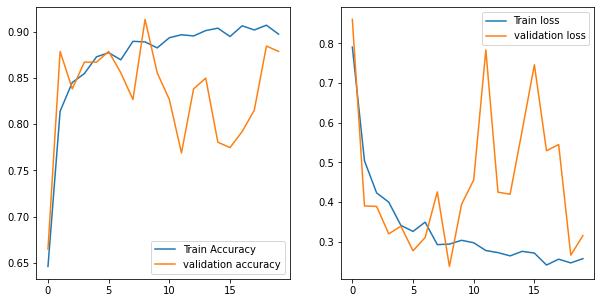

In [56]:
md.graphs(model_history, 20)

# Testing

In [90]:
def predict(img_path, model):
    img_array = cv.imread(img_path)
    plt.imshow(img_array)
    class_names = ['Early_blight','Late_blight', 'healthy']
    img_array = cv.cvtColor(img_array, cv.COLOR_BGR2GRAY)
    img_array = cv.resize(img_array,(IMAGE_SIZE,IMAGE_SIZE), interpolation = cv.INTER_CUBIC)
    img_array = img_array/255.0
    img_array = img_array.reshape(IMAGE_SIZE,IMAGE_SIZE,1)
    img_array = tf.expand_dims(img_array,0)
    predictions = model_loaded.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = round(100*(np.max(predictions[0])),2)

    return f"Predicted Class is {predicted_class} with a confidence of {confidence}%"


'Predicted Class is healthy with a confidence of 91.44%'

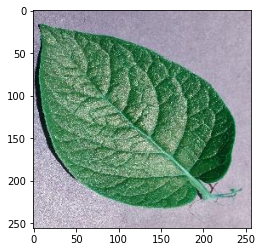

In [91]:
predict('3a1dbeee-089c-43f0.JPG', model_loaded)

'Predicted Class is Early_blight with a confidence of 99.98%'

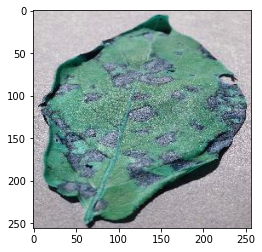

In [92]:
predict('1004a595.JPG',model_loaded)